In [16]:
import dill
import pandas as pd
import os
import random
import pickle

### Baseline Error Analysis

In [5]:
BASELINE_DIR = 'trajectories_gemini'
TRAINDATA_DIR = 'trajectories_train'
TEST_DIR = 'trajectories_test'
ENVS = {
 'click-tab-2-hard':20,
 'social-media':15,
 'email-inbox':30,
 'social-media-some':30,
 'tic-tac-toe':10,
 'use-autocomplete':10,
 'book-flight':30,
 'choose-date':20,
 'search-engine':20
,'click-checkboxes-soft':10}

In [29]:
def count_missed_elements(d,action):
    for env, elements in d.items():
        path = os.path.join(BASELINE_DIR,env)
        files = os.listdir(path)
        for file in files:
            count_not_found = 0
            element_found = False
            filename = os.path.join(path,file)
            with open(filename,'rb') as file:
                trajectory = pickle.load(file)
            actions = [x['action'] for x in trajectory['states']]
            for element in elements:
                search_for = '{} - {}'.format(action,element)
                for action in actions:
                    if search_for in action:
                        element_found = True
                        break
            if not element_found:
                    count_not_found += 1
        print(env,count_not_found/len(files))

### Failure to click on textboxes before writing

In [24]:
envs1 = {'book-flight':[7,9],'choose-date':[5],'search-engine':[5],'use-autocomplete':[5]}
action = 'CLICK_ELEMENT'

count_missed_elements(envs1,action)          

book-flight 0.016666666666666666
choose-date 0.016666666666666666
search-engine 0.08333333333333333
use-autocomplete 0.016666666666666666


### Failure to click on autocomplete

In [30]:
def count_missed_elements2(d,action):
    for env, elements in d.items():
        path = os.path.join(BASELINE_DIR,env)
        files = os.listdir(path)
        for file in files:
            count_not_found = 0
            element_found = False
            filename = os.path.join(path,file)
            with open(filename,'rb') as file:
                trajectory = pickle.load(file)
            actions = [x['action'] for x in trajectory['states']]
            for element in elements:
                for action in actions:
                    if str(element) not in action:
                        element_found = True
                        break
            if not element_found:
                    count_not_found += 1
        print(env,count_not_found/len(files))
envs1 = {'book-flight':[20,24]}
envs2 = {'use-autocomplete':[5]}
action = 'CLICK_ELEMENT'
count_missed_elements(envs1,action)   
count_missed_elements2(envs2,action)   

book-flight 0.016666666666666666
use-autocomplete 0.0


### Find same goal in baseline and train trajectory

In [42]:
env = 'use-autocomplete'
def find_same_goal(env):
    files = []
    paths = [BASELINE_DIR,TRAINDATA_DIR]
    for i,path in enumerate(paths):
        paths[i] = os.path.join(path,env)
        files.append(os.listdir(paths[i]))
    for file in files[0]:
        if env not in file:
            continue
        filename = os.path.join(paths[0],file)
        with open(filename,'rb') as file:
            trajectory = pickle.load(file)
        goal = trajectory['utterance']
        for file1 in files[1]:
            if env not in file1:
                continue
            filename1 = os.path.join(paths[1],file1)
            with open(filename1,'rb') as file:
                trajectory1 = pickle.load(file)
            goal1 = trajectory1['utterance']
            if goal == goal1:
                return(filename,filename1)
find_same_goal(env)

('trajectories_gemini/use-autocomplete/use-autocomplete24.pkd',
 'trajectories_train/use-autocomplete/use-autocomplete105.pkd')

In [43]:
def plot_trajectory(trajectory, cols=4, filename = 'trajectory.png'):
    from mpl_toolkits.axes_grid1 import ImageGrid
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    import math
    '''Plots screenshots of every observation in a trajectory
    input: images (list of np.arrays)
           actions (list of strings from parse_response 'action_text') 
           cols (int - number of columns for constructing the grid)
           filename (str with filename where to save the trajectory picture)'''
    actions = [x['action'] for x in trajectory['states']]
    images = [x['screenshot'] for x in trajectory['states']]
    rows = math.ceil(len(images) / cols)

    fig = plt.figure(figsize=(12*rows,8*cols))
    grid = ImageGrid(fig, 111, nrows_ncols = (rows,cols), axes_pad = 1)
    titles = ['{}.'.format(x[0]+1,x[1]) for x in enumerate(actions)]
    for i,image in enumerate(images):
        grid[i].axis('off')
        grid[i].set_title(titles[i])
        grid[i].imshow(image.astype(int))
    plt.savefig(filename,bbox_inches='tight')

Goal: Use the textbox to enter "Sergio" and press "Search", then find and click the 4th search result.
Reward: 0.0
Actions:
1 - Click on the search textbox. - CLICK_ELEMENT 5
2 - Type Sergio into the search textbox. - TYPE_TEXT 5
3 - Click on the search textbox (again, to trigger autocomplete). - CLICK_ELEMENT 5


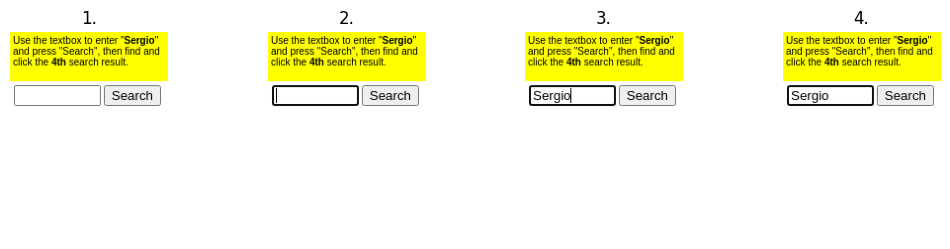

In [48]:
with open(BASELINE_DIR+'/search-engine/search-engine11.pkd','rb') as file:
    trajectory = pickle.load(file)
print('Goal:',trajectory['utterance'])
print('Reward:',trajectory['reward'])
print('Actions:')
for i,state in enumerate(trajectory['states'][1:]):
    print(i+1,'-',state['action'])
plot_trajectory(trajectory)

Goal: Use the textbox to enter "Sergio" and press "Search", then find and click the 4th search result.
Reward: 0.87335
Actions:
1 - Click on the textbox - CLICK_ELEMENT 5
2 - Now that you have clicked on the textbox, type Sergio in the textbox - TYPE_TEXT 5
3 - Click on the Search button - CLICK_ELEMENT 6
4 - Counted 3 results so far. Go to page 2 because Sergio was not found on page 1 - CLICK_ELEMENT 24
5 - Counted 4 results, click Search Title Sergio in position 1 - CLICK_ELEMENT 30


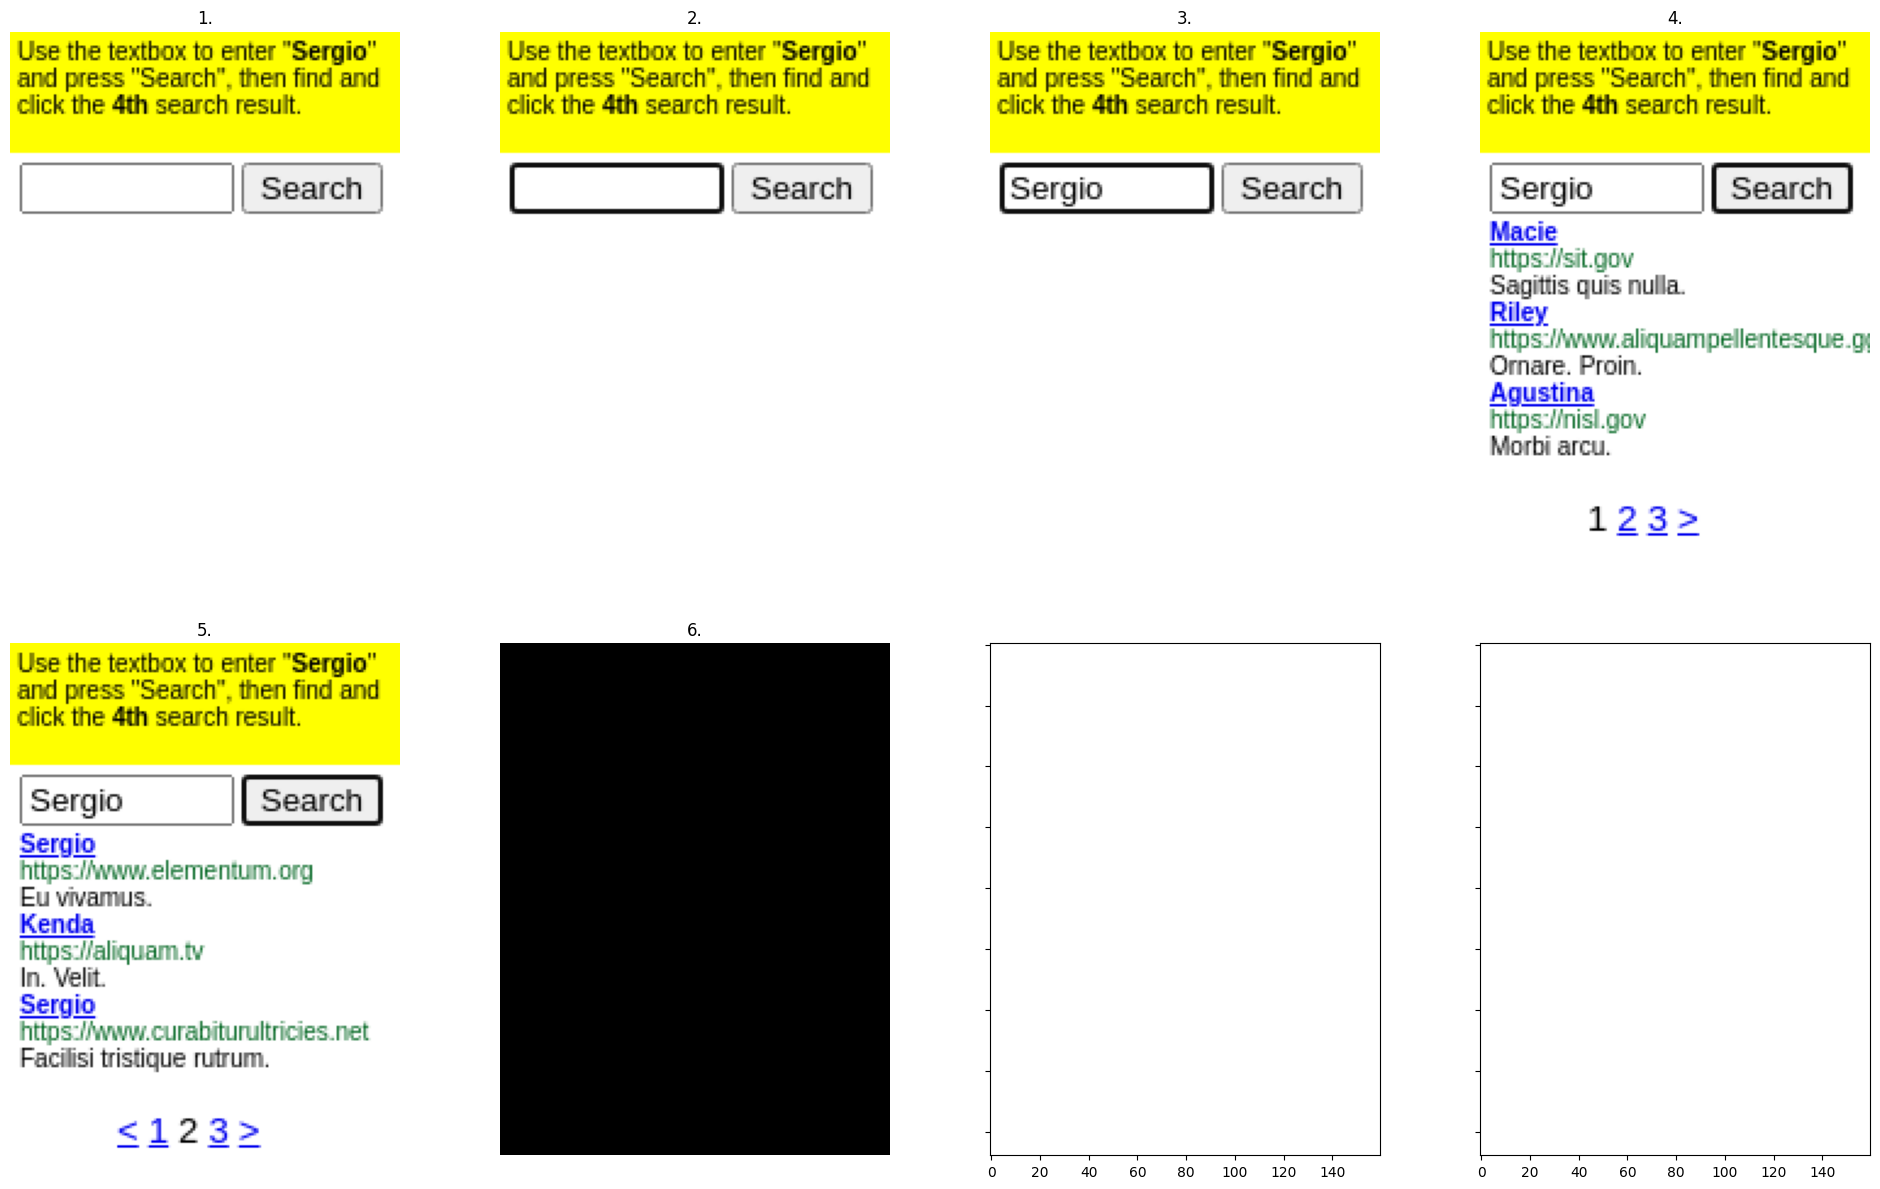

In [49]:
with open(TRAINDATA_DIR+'/search-engine/search-engine179.pkd','rb') as file:
    trajectory = pickle.load(file)
print('Goal:',trajectory['utterance'])
print('Reward:',trajectory['reward'])
print('Actions:')
for i,state in enumerate(trajectory['states'][1:]):
    print(i+1,'-',state['action'])
plot_trajectory(trajectory)

Goal: Use the textbox to enter "Sergio" and press "Search", then find and click the 4th search result.
Reward: 0.89624
Actions:
1 - Click on the textbox - CLICK_ELEMENT 5
2 - Type Sergio in the textbox - TYPE_TEXT 5
3 - Click on the Search button - CLICK_ELEMENT 6
4 - Go to page 2 because Sergio was not found on page 1 - CLICK_ELEMENT 24
5 - Click Search Title Sergio in position 1 - CLICK_ELEMENT 30


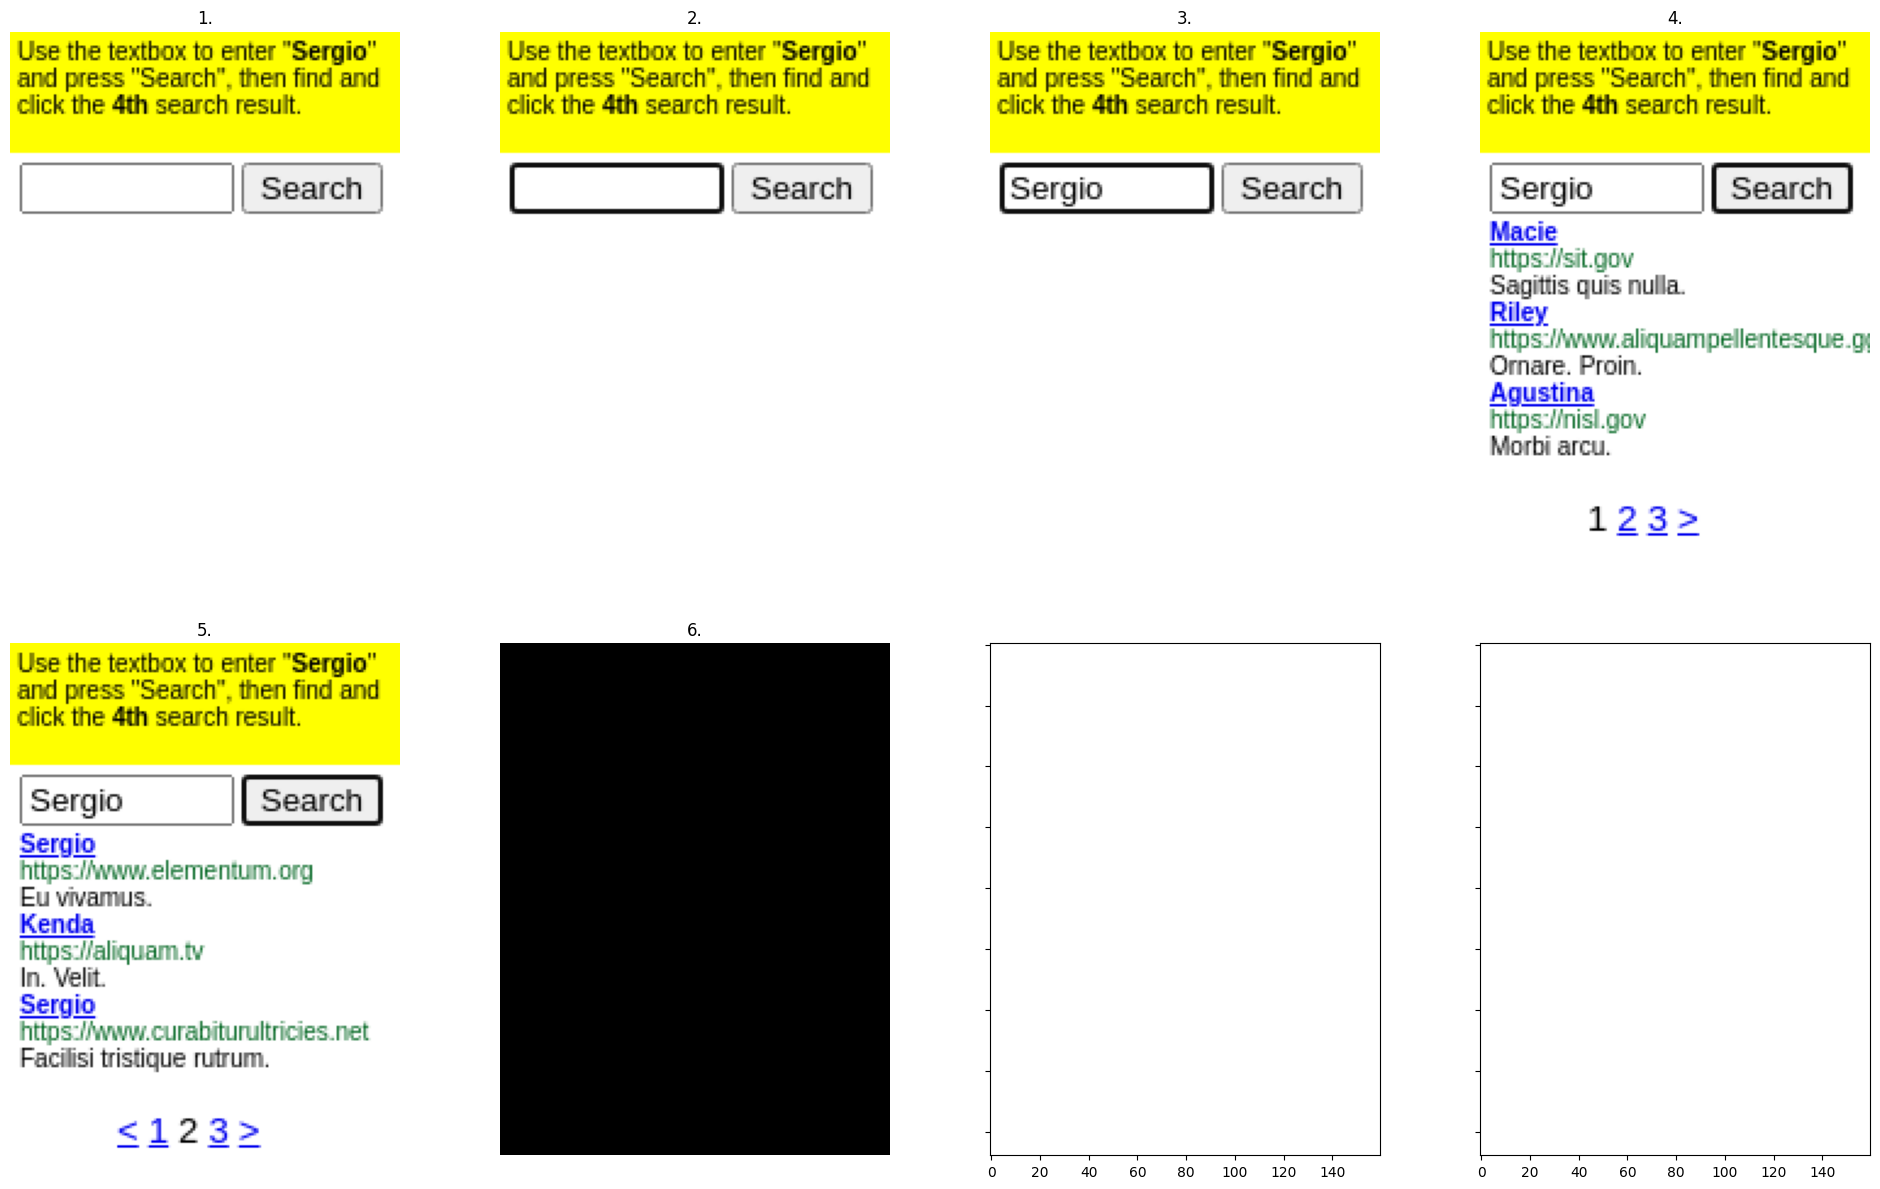

In [51]:
## For illustrative purposes
actions = ['Click on the textbox - CLICK_ELEMENT 5',
'Type Sergio in the textbox - TYPE_TEXT 5',
'Click on the Search button - CLICK_ELEMENT 6',
'Go to page 2 because Sergio was not found on page 1 - CLICK_ELEMENT 24',
'Click Search Title Sergio in position 1 - CLICK_ELEMENT 30']
print('Goal:',trajectory['utterance'])
print('Reward:',.89624)
print('Actions:')
for i,action in enumerate(actions):
    print(i+1,'-',action)
plot_trajectory(trajectory)

### Find distribution of train and test dates

In [79]:
def collect_dates():
    import re
    
    env = 'choose-date'
    files = {}
    paths = [TRAINDATA_DIR, TEST_DIR]
    files['train'] = [os.path.join(os.path.join(TRAINDATA_DIR,env),x) for x in os.listdir(os.path.join(TRAINDATA_DIR,env))]
    path_test = os.path.join(TEST_DIR,'model_full1')
    files['test'] = [os.path.join(path_test,x) for x in  os.listdir(path_test)]
    months_train = []
    for filename in files['train']:
        if 'checkpoints' in filename:
            continue
        with open(filename,'rb') as file:
            trajectory = pickle.load(file)
        month = re.search('Select ([0-9]+)\/',trajectory['utterance']).group(1)
        if month =='07':
            print(filename)
        months_train.append(month)
    months_test = []
    for filename in files['test']:
        if 'checkpoints' in filename or env not in filename:
            continue
        with open(filename,'rb') as file:
            trajectory = pickle.load(file)
        month = re.search('Select ([0-9]+)\/',trajectory['utterance']).group(1)
        if month =='07':
            print(filename)
        months_test.append(month)
    df_train = pd.DataFrame()
    df_train['Train Months'] = months_train
    df_test = pd.DataFrame()
    df_test['Test Months'] = months_test
    return df_train, df_test
df_train, df_test=collect_dates()


trajectories_train/choose-date/choose-date031.pkd
trajectories_train/choose-date/choose-date008.pkd
trajectories_train/choose-date/choose-date029.pkd
trajectories_train/choose-date/choose-date022.pkd
trajectories_train/choose-date/choose-date028.pkd
trajectories_train/choose-date/choose-date092.pkd
trajectories_train/choose-date/choose-date018.pkd
trajectories_test/model_full1/choose-date024.pkd
trajectories_test/model_full1/choose-date025.pkd
trajectories_test/model_full1/choose-date020.pkd
trajectories_test/model_full1/choose-date004.pkd
trajectories_test/model_full1/choose-date018.pkd


In [80]:
import altair as alt
alt.Chart(df_train).mark_bar(color='orange').encode(
    alt.X('Train Months:Q', bin=alt.Bin(maxbins=30)),
    alt.Y('count()'))

alt.Chart(...)

In [81]:
alt.Chart(df_test).mark_bar(color='orange').encode(
    alt.X('Test Months:Q', bin=alt.Bin(maxbins=30)),
    alt.Y('count()'))

alt.Chart(...)

Goal: Select 07/12/2016 as the date and hit submit.
Reward: 0.75395
Actions:
1 - Click on datepicker - CLICK_ELEMENT 5
2 - You are currently in December. Click on Prev to change month from December to November, because 12>7 - CLICK_ELEMENT 10
3 - You are currently in November. Click on Prev to change month from November to October, because 11>7 - CLICK_ELEMENT 107
4 - You are currently in October. Click on Prev to change month from October to September, because 10>7 - CLICK_ELEMENT 203
5 - You are currently in September. Click on Prev to change month from September to August, because 9>7 - CLICK_ELEMENT 308
6 - You are currently in August. Click on Prev to change month from August to July, because 8>7 - CLICK_ELEMENT 404
7 - Click on day 12 of July because you have already navigated to the right month (July) - CLICK_ELEMENT 556
8 - Click on Submit - CLICK_ELEMENT 6


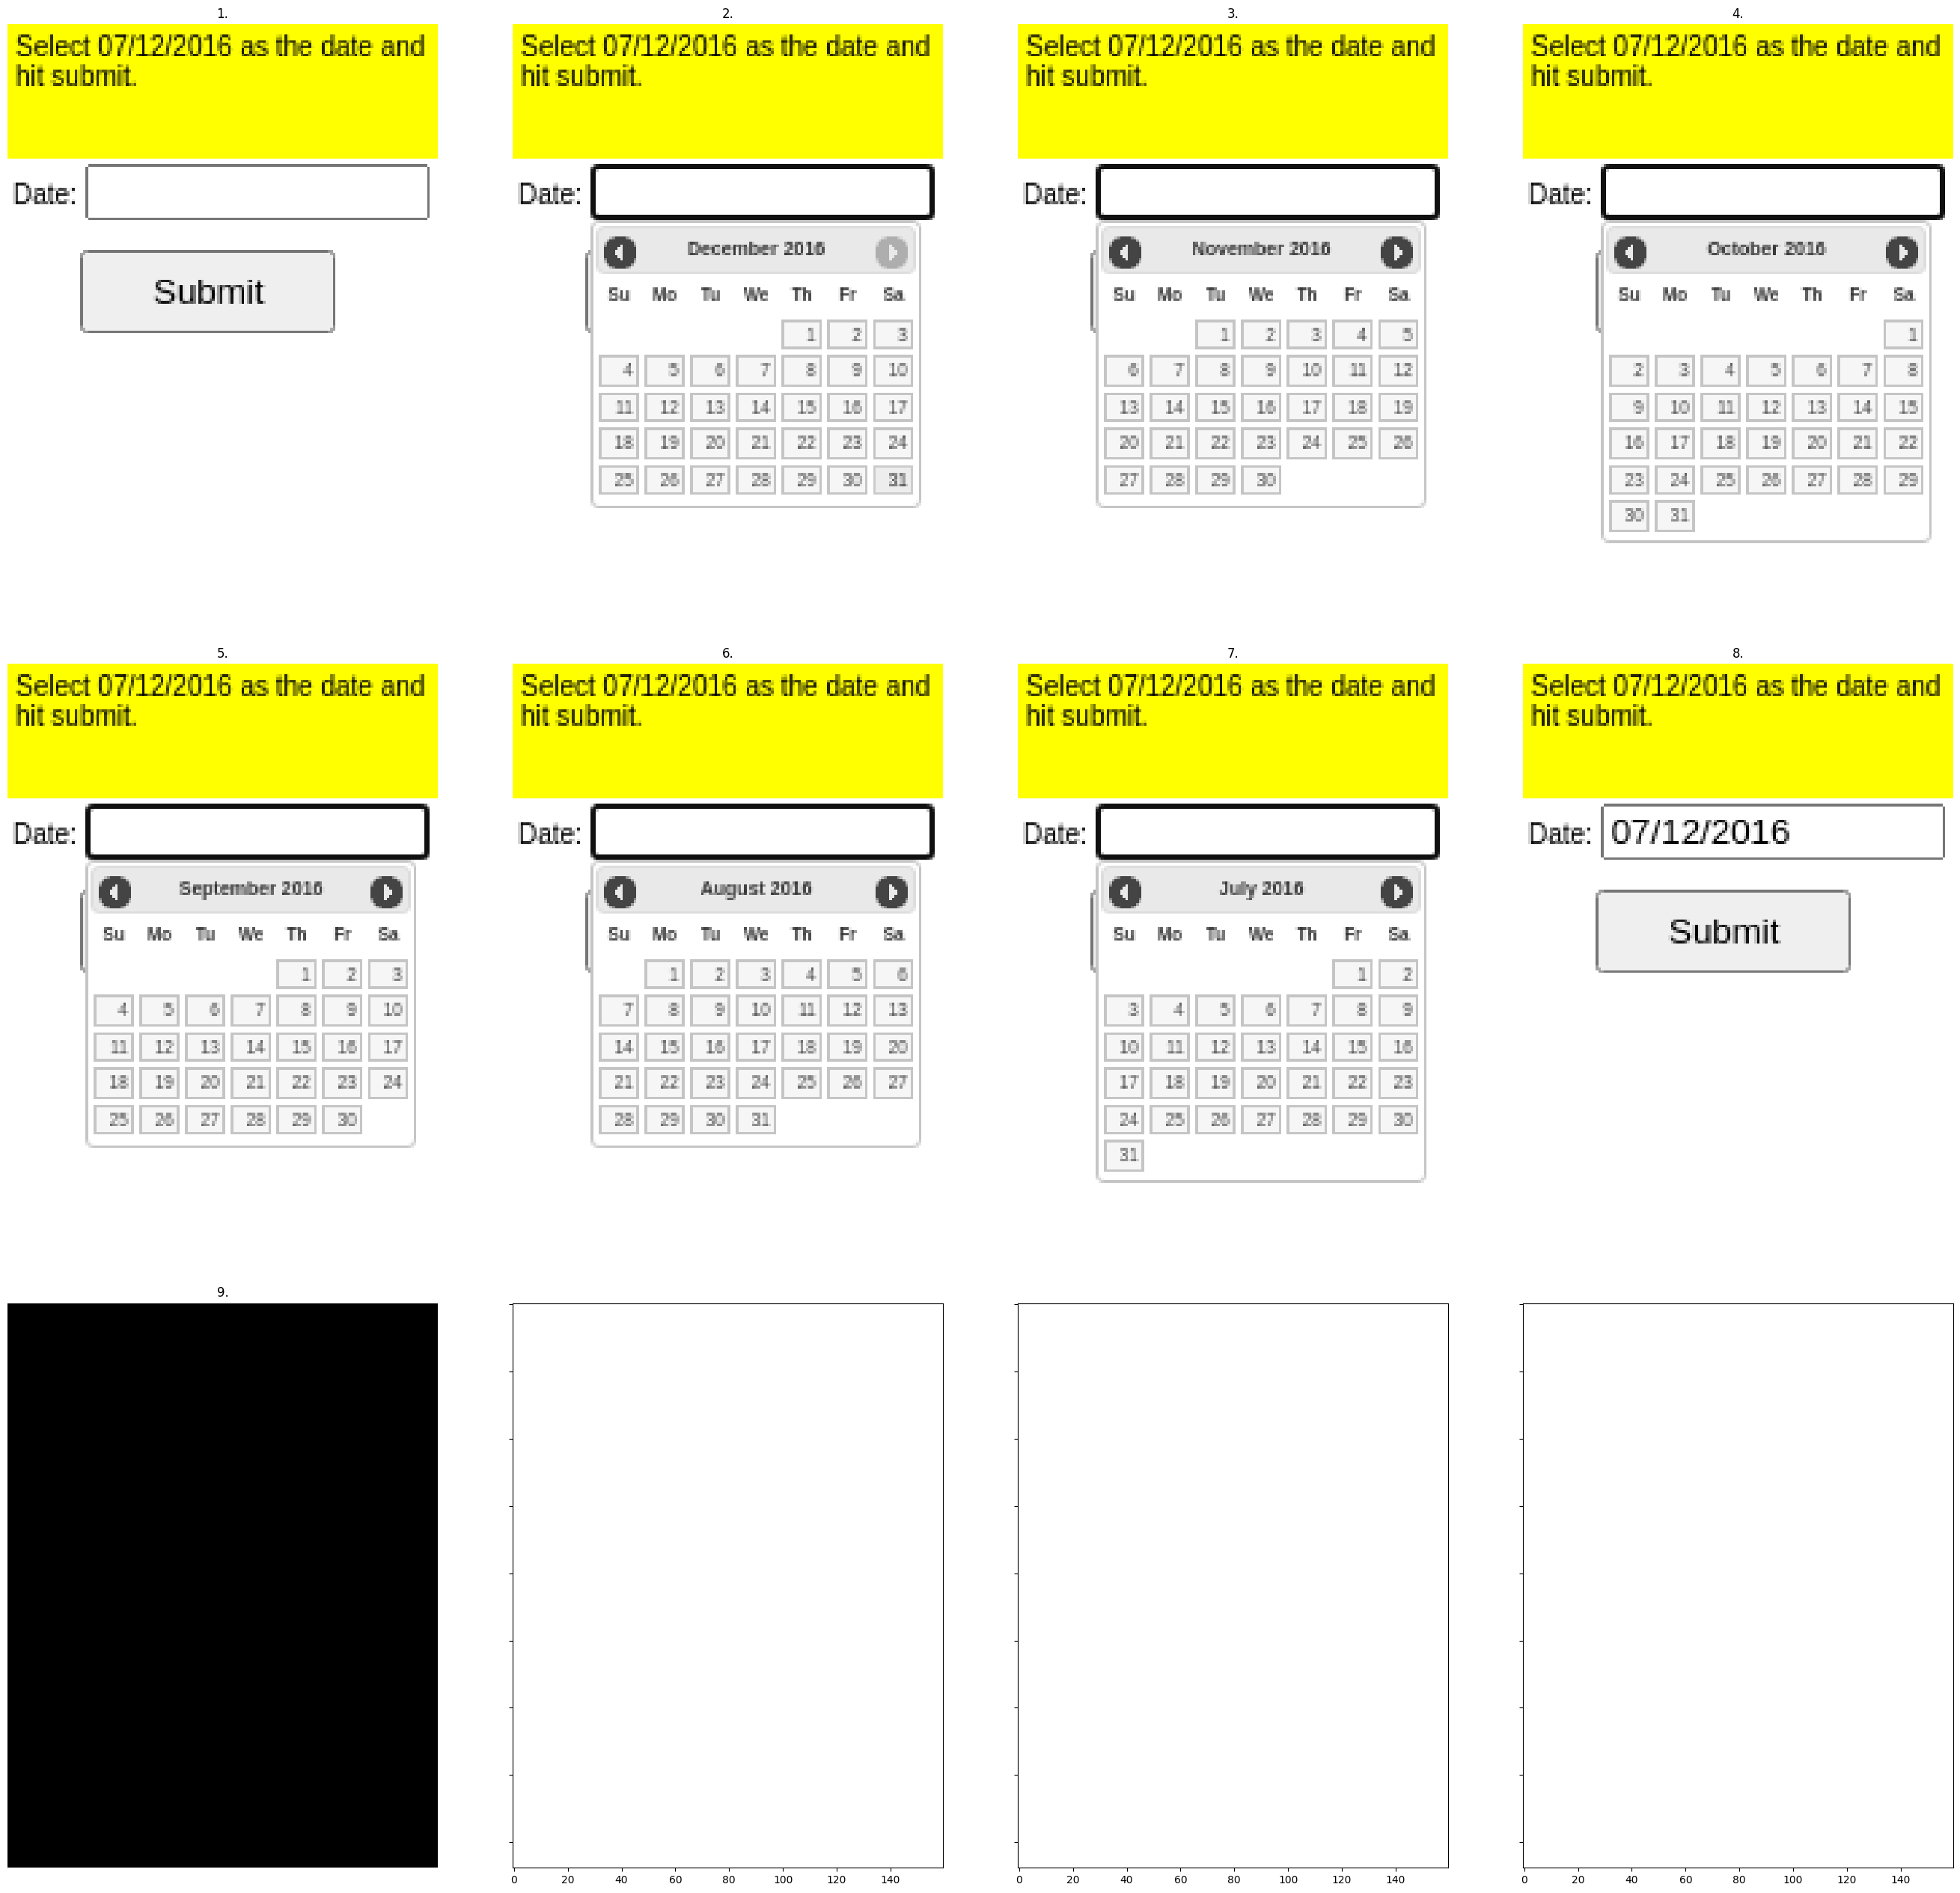

In [76]:
with open('trajectories_train/choose-date/choose-date031.pkd','rb') as file:
    trajectory = pickle.load(file)
print('Goal:',trajectory['utterance'])
print('Reward:',trajectory['reward'])
print('Actions:')
for i,state in enumerate(trajectory['states'][1:]):
    print(i+1,'-',state['action'])
plot_trajectory(trajectory)

Goal: Select 07/15/2016 as the date and hit submit.
Reward: -1.0
Actions:
1 - Click on input field - CLICK_ELEMENT 5
2 - Click on day 15 of December because you have already navigated to the right month (December) - CLICK_ELEMENT 70
3 - Click on datepicker - CLICK_ELEMENT 5
4 - You are currently in December. Click on Prev to change month from December to November, because 12>7 - CLICK_ELEMENT 106
5 - You are currently in November. Click on Prev to change month from November to October, because 11>7 - CLICK_ELEMENT 204
6 - You are currently in October. Click on Prev to change month from October to September, because 10>7 - CLICK_ELEMENT 299
7 - Click on day 15 of September because you have already navigated to the right month (September) - CLICK_ELEMENT 465
8 - Click on datepicker - CLICK_ELEMENT 5
9 - Click on day 15 of September because you have already navigated to the right month (September) - CLICK_ELEMENT 531
10 - Click on datepicker - CLICK_ELEMENT 5
11 - You are currently in Sep

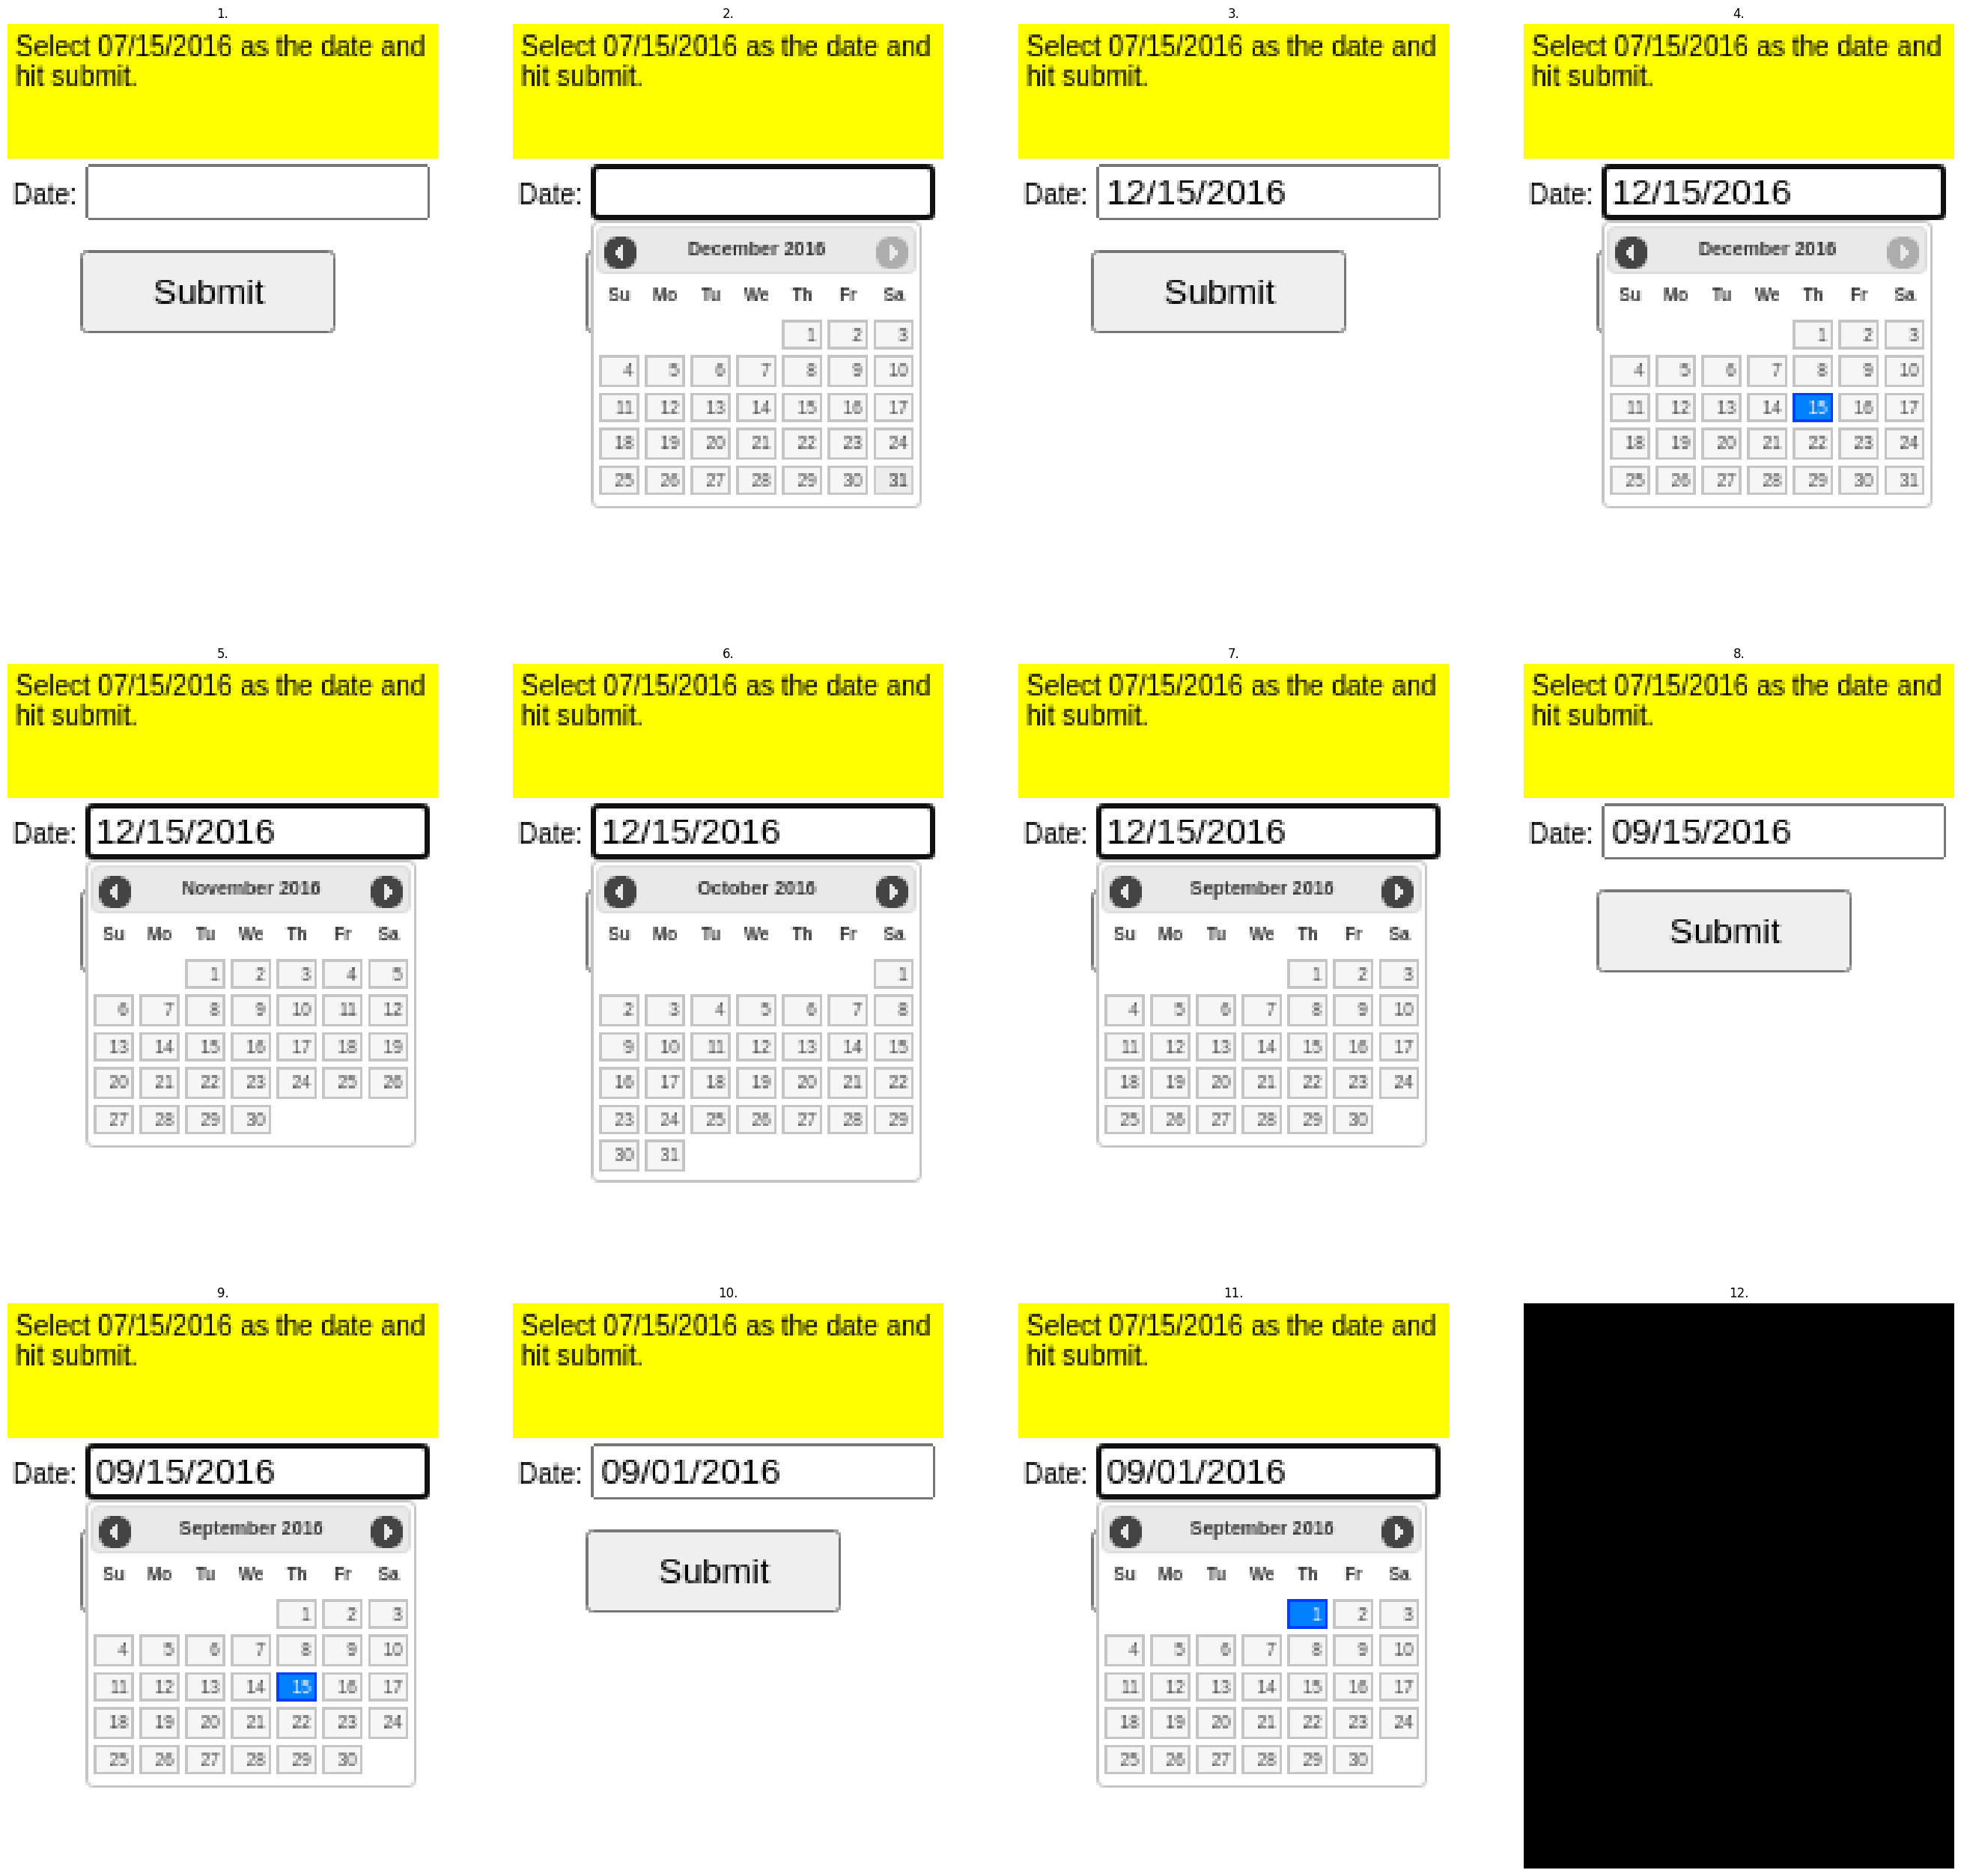

In [82]:
with open('trajectories_test/model_full1/choose-date024.pkd','rb') as file:
    trajectory = pickle.load(file)
print('Goal:',trajectory['utterance'])
print('Reward:',trajectory['reward'])
print('Actions:')
for i,state in enumerate(trajectory['states'][1:]):
    print(i+1,'-',state['action'])
plot_trajectory(trajectory)

### Analyze individual trajectories

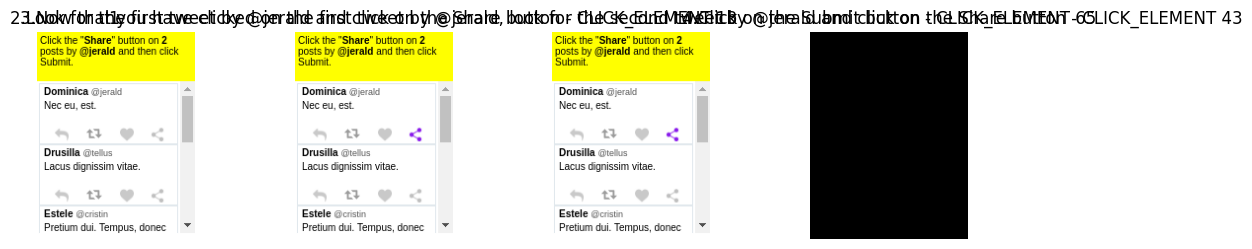

In [116]:


trajectory = dill.load(open('trajectories_train/social-media-some/social-media-some036.pkd', 'rb'))
plot_trajectory(trajectory)

In [117]:
print(trajectory['utterance'])
print(trajectory['reward'])
[x['action'] for x in trajectory['states']]

Click the "Share" button on 2 posts by @jerald and then click Submit.
0.7697


['',
 'Look for the first tweet by @jerald and click on the Share button - CLICK_ELEMENT 13',
 'Now that you have clicked on the first tweet by @jerald, look for the second tweet by @jerald and click on the Share button - CLICK_ELEMENT 43',
 'Click on the Submit button - CLICK_ELEMENT 65']

In [113]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
trajectory['states'][1]['dom_elements']

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

In [72]:
pip install together

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install scikit-learn

     ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
     --------------------------------------- 0.0/11.0 MB 217.9 kB/s eta 0:00:51
     --------------------------------------- 0.0/11.0 MB 217.9 kB/s eta 0:00:51
     --------------------------------------- 0.0/11.0 MB 245.8 kB/s eta 0:00:45
     --------------------------------------- 0.1/11.0 MB 301.2 kB/s eta 0:00:37
     --------------------------------------- 0.1/11.0 MB 420.8 kB/s eta 0:00:26
      -------------------------------------- 0.2/11.0 MB 586.1 kB/s eta 0:00:19
      -------------------------------------- 0.2/11.0 MB 684.7 kB/s eta 0:00:16
     - ------------------------------------- 0.3/11.0 MB 873.8 kB/s eta 0:00:13
     - -------------------------------------- 0.5/11.0 MB 1.1 MB/s eta 0:00:10
     -- ------------------------------------- 0.6/11.0 MB 1.2 MB/s eta 0:00:09
     -- ------------------------------------- 0.7/11.0 MB 

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
from typing import List
from together import Together

client = Together(api_key='dcbe550aeb2c478d292bd89de106c79a9b706315d096d71353ab44aea2a0c22a')

def get_embeddings(texts: List[str], model: str) -> List[List[float]]:
    texts = [text.replace("\n", " ") for text in texts]
    outputs = client.embeddings.create(model=model, input=texts)
    return [outputs.data[i].embedding for i in range(len(texts))]

input_texts = ['Our solar system orbits the Milky Way galaxy at about 515,000 mph']
embeddings = get_embeddings(input_texts, model='togethercomputer/m2-bert-80M-8k-retrieval')


In [21]:
cosine_similarity(embeddings,embeddings)

array([[1.]])

In [40]:
def get_benchmark_trajectory(env_name):
    number = random.choice(range(50))
    filename = TRAIN_STATS[TRAIN_STATS.env_name == env_name].filename.values[number]
    trajectory = dill.load(open(filename,'rb'))
    actions = [x['action'] for x in trajectory['states'][1:]]
    print(env_name)
    print(trajectory['utterance'])
    print(['{} - {}'.format(x[0]+1,x[1]) for x in enumerate(actions)])
    return actions
    
def create_benchmarks():
    ''' returns dictionary with one benchmark trajectory for each environment'''
    benchmarks = {}
    for env_name in ENVS:
        benchmarks[env_name] = get_benchmark_trajectory(env_name)
    return benchmarks
create_benchmarks()

click-tab-2-hard
Switch between the tabs to find and click on the link "id".
['1 - Click on tab number 2 because the link was not found in tab 1 - CLICK_ELEMENT 8', '2 - Click on link id  - CLICK_ELEMENT 24']
social-media
For the user @leonie, click on the "Mute" button.
['1 - Look for the tweet by @leonie and click on the MORE button (3 dots) - CLICK_ELEMENT 42', '2 - Select the Mute option from the MORE dropdown menu - CLICK_ELEMENT 86']
email-inbox
Find the email by Nelli and forward that email to Cal.
['1 - Click on the thread by Nelli - CLICK_ELEMENT 28', '2 - Click on the Forward icon - CLICK_ELEMENT 72', '3 - Click on the input box next to the word To - CLICK_ELEMENT 80', '4 - Type Cal on the input box next to the word To - TYPE_TEXT 80', '5 - Click on the send-forward icon - CLICK_ELEMENT 76']
social-media-some
Click the "Share" button on 2 posts by @adipiscing and then click Submit.
['1 - Look for a tweet by @adipiscing and click on the Share button - CLICK_ELEMENT 93', '2 - L

{'click-tab-2-hard': ['Click on tab number 2 because the link was not found in tab 1 - CLICK_ELEMENT 8',
  'Click on link id  - CLICK_ELEMENT 24'],
 'social-media': ['Look for the tweet by @leonie and click on the MORE button (3 dots) - CLICK_ELEMENT 42',
  'Select the Mute option from the MORE dropdown menu - CLICK_ELEMENT 86'],
 'email-inbox': ['Click on the thread by Nelli - CLICK_ELEMENT 28',
  'Click on the Forward icon - CLICK_ELEMENT 72',
  'Click on the input box next to the word To - CLICK_ELEMENT 80',
  'Type Cal on the input box next to the word To - TYPE_TEXT 80',
  'Click on the send-forward icon - CLICK_ELEMENT 76'],
 'social-media-some': ['Look for a tweet by @adipiscing and click on the Share button - CLICK_ELEMENT 93',
  'Look for a tweet by @adipiscing and click on the Share button - CLICK_ELEMENT 113',
  'Click on the Submit button - CLICK_ELEMENT 115'],
 'tic-tac-toe': ['Click on any empty square - CLICK_ELEMENT 5',
  'Click on a square in a row, column or diagonal 

In [ ]:
def get_baseline_trajectory(env_name):
    filename = TRAIN_STATS[TRAIN_STATS.env_name == env_name].filename.values[0]
    trajectory = dill.load(open(filename,'rb'))
    actions = [x['action'] for x in trajectory['states'][1:]]
    print(env_name)
    print(trajectory['utterance'])
    print(['{} - {}'.format(x[0]+1,x[1]) for x in enumerate(actions)])
    return actions